In [3]:
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=np.nan)
from sklearn.metrics.pairwise import cosine_similarity


from fuzzywuzzy import process 

import re
#lets try tfidf
#from sklearn.feature_extraction.text import   TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer()

import nltk
#import plotly.plotly as py
#import plotly.tools as tls

import matplotlib.pyplot as plt

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

#https://rare-technologies.com/word2vec-tutorial/
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import seaborn as sns



In [4]:
products=pd.read_csv('Products.csv',low_memory=False)  

products.head()
products2=products[products.long_name.notnull()].drop_duplicates(subset=['ingredients_english']) 
products2['name']=products2.long_name.str.lower()
products2['ingredients']=products2.ingredients_english.str.lower()

In [212]:
products2.name.head()

0       mochi ice cream bonbons
1       chipotle barbecue sauce
2    hot & spicy barbecue sauce
3                barbecue sauce
4                barbecue sauce
Name: name, dtype: object

In [196]:
len(products2),len(products)

(95358, 119546)

In [182]:
products2.ingredients.head(10)

0    ice cream ingredients: milk, cream, sugar, str...
1    water, sugar, tomato paste, molasses, distille...
2    sugar, water, distilled vinegar, tomato paste,...
3    tomato puree (water, tomato paste), sugar, dis...
4    sugar, distilled vinegar, water, tomato paste,...
5    sugar, distilled vinegar, water, tomato paste,...
6    sugar, distilled vinegar, water, tomato puree ...
7    water, sugar, tomato paste, molasses, distille...
8    tomato puree, onion puree, sugar, molasses, di...
9    organic grain vinegar, water, organic mustard ...
Name: ingredients, dtype: object

In [183]:
products2.ingredients[0]

'ice cream ingredients: milk, cream, sugar, strawberries (strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum, mono & diglycerides, beet juice and beet powder (for color), cellulose gum, locust bean gum, carrageenan. coating ingredients: sugar, water, rice flour, trehalose, egg whites, beet juice and beet powder (for color), dusted with corn & potato starch'

In [239]:
products2=products2[products2.NDB_Number.notnull()]

# Pull in NUTRITION info

In [5]:
nutr=pd.read_csv('nutrinfo.csv',low_memory=False).drop(['NDB_Number', 'NDB_No', 'long_name','manufacturer','ingredients_english'],axis=1)

In [243]:
nutr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65442 entries, 0 to 65441
Data columns (total 21 columns):
Unnamed: 0                    65442 non-null int64
satfat                        57006 non-null float64
satfat_uom                    57006 non-null object
gtin_upc                      65442 non-null float64
Matches                       0 non-null float64
energy                        64569 non-null float64
energy_uom                    64569 non-null object
sodium                        65235 non-null float64
sodium_uom                    65235 non-null object
protein                       65336 non-null float64
protein_uom                   65336 non-null object
fat                           65402 non-null float64
fat_uom                       65402 non-null object
carbs                         65397 non-null float64
carbs_uom                     65397 non-null object
energy_new                    65277 non-null float64
Serving_Size                  65316 non-null float64
Se

In [6]:
pronutr=pd.merge(products2,nutr, 
                 on=['gtin_upc'],how='inner')
print([len (x) for x in [pronutr,nutr,products2]])
pronutr.info()

[65477, 65442, 95358]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 65477 entries, 0 to 65476
Data columns (total 30 columns):
NDB_Number                    65477 non-null object
long_name                     65477 non-null object
data_source                   65477 non-null object
gtin_upc                      65477 non-null float64
manufacturer                  65477 non-null object
date_modified                 65477 non-null object
date_available                65477 non-null object
ingredients_english           65477 non-null object
name                          65477 non-null object
ingredients                   65477 non-null object
Unnamed: 0                    65477 non-null int64
satfat                        57039 non-null float64
satfat_uom                    57039 non-null object
Matches                       0 non-null float64
energy                        64596 non-null float64
energy_uom                    64596 non-null object
sodium                        65270 no

In [246]:
pronutr.head()

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,pcat,pcat2,...,fat,fat_uom,carbs,carbs_uom,energy_new,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45001581,SLICED BLACK FOREST HAM,LI,8.523927e+10,Target Stores,2018-03-11 02:23:22,2018-03-11 02:23:22,"PORK CURED WITH: WATER, DEXTROSE, CONTAINS LES...",sliced black forest ham,True,...,4.46,g,3.57,g,125.86,56.0,g,2.0,ONZ,NaN
1,45001582,SLICED BLACK ANGUS ROAST BEEF,LI,8.523927e+10,Target Stores,2018-03-11 02:26:59,2018-03-11 02:26:59,"BEEF, WATER, CONTAINS LESS THAN 2% SODIUM LACT...",sliced black angus roast beef,True,...,8.04,g,1.79,g,165.24,56.0,g,2.0,ONZ,NaN
2,45001591,TRADITIONAL HUMMUS,LI,8.523923e+10,Target Stores,2018-03-11 02:18:21,2018-03-11 02:18:21,"CHICKPEAS, WATER, SESAME TAHINI, CANOLA/OLIVE ...",traditional hummus,False,...,16.07,g,21.43,g,258.91,28.0,g,2.0,Tbsp,NaN
3,45001595,SPICY THREE PEPPER HUMMUS,LI,8.523923e+10,Target Stores,2018-03-11 02:29:46,2018-03-11 02:29:46,"CHICKPEAS, WATER, SESAME TAHINI, CANOLA/OLIVE ...",spicy three pepper hummus,False,...,14.29,g,21.43,g,242.89,28.0,g,2.0,Tbsp,NaN
4,45001596,ROASTED RED PEPPER HUMMUS,LI,8.523923e+10,Target Stores,2018-03-11 02:16:16,2018-03-11 02:16:16,"CHICKPEAS, ROASTED RED PEPPERS, SESAME TAHINI,...",roasted red pepper hummus,False,...,12.50,g,17.86,g,212.50,28.0,g,2.0,Tbsp,NaN


In [226]:
products2.info(),nutr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95358 entries, 0 to 119544
Data columns (total 12 columns):
NDB_Number             95358 non-null object
long_name              95358 non-null object
data_source            95358 non-null object
gtin_upc               95358 non-null float64
manufacturer           95358 non-null object
date_modified          95358 non-null object
date_available         95358 non-null object
ingredients_english    95357 non-null object
pcat                   95358 non-null object
pcat2                  95358 non-null object
name                   95358 non-null object
ingredients            95357 non-null object
dtypes: float64(1), object(11)
memory usage: 9.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65442 entries, 0 to 65441
Data columns (total 26 columns):
Unnamed: 0                    65442 non-null int64
NDB_No                        65442 non-null int64
satfat                        57006 non-null float64
satfat_uom                    57

(None, None)

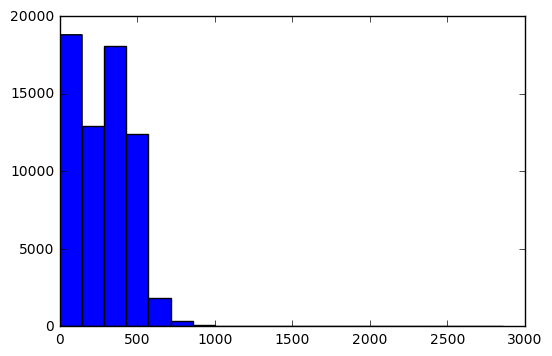

In [82]:
plt.hist(pronutr.energy[pronutr['energy'].notnull()] ,bins=20)
plt.show() 

In [7]:
pronutr['pcat']= pronutr['name'].str.contains('ice cream')
#np.where(pronutr[pronutr['name'].str.contains('ice cream')],  'ice cream','noticecream')
 
pronutr['pcat'].value_counts()

False    64052
True      1425
Name: pcat, dtype: int64

In [9]:
pronutr['pcat']=np.where(pronutr['name'].str.contains('ice cream'),  'ice cream','nocat')


pronutr['pcat'].value_counts()

nocat        64052
ice cream     1425
Name: pcat, dtype: int64

In [10]:
icecream=pronutr[pronutr.pcat=='ice cream']
icecream=icecream.fillna(0)
len(icecream)

1425

In [11]:

icecream['proteinq']=pd.cut(icecream['protein'], 5, labels=False)
icecream['hipro']=np.where(icecream['proteinq']==4,1,0)

icecream['carbsq']=pd.cut(icecream['carbs'], 5, labels=False)
icecream['lowcarb']=np.where(icecream['carbsq']==0,1,0)

icecream['fatq']=pd.cut(icecream['fat'], 5, labels=False)
icecream['lowfat']=np.where(icecream['fatq']==0,1,0)
 
icecream['enq']=pd.cut(icecream['energy_new'], 5, labels=False)
icecream['lowcal']=np.where(icecream['enq']==0,1,0) 
icecream.head()

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,name,ingredients,...,Preparation_State,pcat,proteinq,hipro,carbsq,lowcarb,fatq,lowfat,enq,lowcal
134,45003417,"JULIE'S, ORGANIC ICE CREAM, TOASTY ALMOND COCO...",LI,7.260974e+10,"Oregon Ice Cream, LLC",2017-11-19 22:56:16,2017-11-19 22:56:16,"ORGANIC COCONUT CREAM, WATER, ORGANIC CANE SUG...","julie's, organic ice cream, toasty almond coco...","organic coconut cream, water, organic cane sug...",...,0,ice cream,1,0,1,0,2,0,2,0
136,45003429,"STRAUS FAMILY CREAMERY, ORGANIC SUPER PREMIUM ...",LI,7.848301e+11,Straus Family Creamery,2017-11-01 18:40:13,2017-11-01 18:40:13,PASTEURIZED ORGANIC CREAM AND ORGANIC NONFAT M...,"straus family creamery, organic super premium ...",pasteurized organic cream and organic nonfat m...,...,0,ice cream,1,0,1,0,2,0,1,0
137,45003432,"DOUBLE RAINBOW, ICE CREAM, MINT CHOCOLATE CHIP",LI,2.285267e+10,"Double Rainbow Gourmet Ice Creams, Inc.",2017-10-18 19:52:19,2017-10-18 19:52:19,"CREAM, MILK, CANE SUGAR, FUDGE CHIPS (SUGAR, C...","double rainbow, ice cream, mint chocolate chip","cream, milk, cane sugar, fudge chips (sugar, c...",...,0,ice cream,1,0,1,0,2,0,2,0
321,45005483,ICE CREAM BAR,LI,7.064001e+10,"Wells Enterprises, Inc.",2018-01-20 02:01:27,2018-01-20 02:01:27,"REDUCED FAT ICE CREAM (MILK, CREAM, SUGAR, COR...",ice cream bar,"reduced fat ice cream (milk, cream, sugar, cor...",...,0,ice cream,2,0,1,0,2,0,2,0
416,45006846,PREMIUM ICE CREAM,LI,4.149701e+10,"Weis Markets, Inc.",2018-03-31 00:16:06,2018-03-31 00:16:06,"NONFAT MILK, CREAM, PEANUT BUTTER SAUCE (PEANU...",premium ice cream,"nonfat milk, cream, peanut butter sauce (peanu...",...,0,ice cream,1,0,1,0,2,0,2,0


In [295]:
df2 = pd.get_dummies(icecream['ingredients'].str.strip()
                     .dropna()
                     #.iloc[:150]
#                     .apply(lambda x: pd.Series([x for x in re.split(r'\W',x) if x!='']))) 
                    .apply(lambda x: pd.Series(re.findall(r'[\w|\s]+',x))), prefix=None, prefix_sep='_')
#df['ingredients_english'].dropna().apply(lambda x: pd.Series(re.findall(r'[\w|\s]+',x)))

df2.head()

,0_100,0_all,0_banana,0_black raspberry ice cream ingredients,0_bleached enriched wheat flour,0_buttermilk,0_cake,0_cake,0_cashew milk,0_chocolate cake,0_chocolate chip cookie,0_chocolate chip cookies,0_chocolate cookie,0_chocolate ice cream,0_chocolate truffle cookies,0_classic chocolate ice cream ingredients,0_coconut ice cream,0_coffee cookie crumble ice cream ingredients,0_coffee ice cream ingredients,0_color me vanilla ice cream ingredients,0_consist of dark chocolate,0_corn syrup,0_cream,0_cream and non fat milk,0_cream and nonfat milk,0_cream milk,0_enriched wheat flour,0_forbidden chocolate ice cream ingredients,0_fresh cream,0_fresh milk,0_fresh whole milk,0_glucose syrup,0_grade a milk,0_graham water ingredients,0_hudson valley fresh milk,0_ice cream,0_ice cream,0_ice cream and decoration ingredients as packaged,0_ice cream base,0_ice cream contains milk,0_ice cream ingredients,0_ice cream mix,0_ice cream portion,0_ice shell ice cream,0_ingredients,0_light chocolate peanut butter swirl ice cream ingredients,0_light ice cream,0_light ice cream,0_low fat ice cream,0_lowfat ice cream,0_lucuma,0_made with fresh milk,0_milk,0_milk,0_milk and cream,0_milk and milk solids,0_milk and skim milk,0_milk chocolate coating,0_milk fat,0_milk fat and non,0_milk fat and nonfat milk,0_milk fat and nonfat milk cookies,0_milkfat,0_milkfat,0_milkfat and nonfat milk,0_milkfat and nonfat milk,0_milkfat and nonfat milk cookies,0_milkfat and nonfat milk corn syrup,0_mini marshmallows ingredients,0_mint chocolate chip ice cream,0_no sugar added low fat ice cream,0_nonfat milk,0_nonfat sherbet,0_nonfat sherbet,0_orange sherbet,0_oreo wafers,0_organic coconut cream,0_organic cream,0_organic cream and organic skim milk,0_organic ice cream,0_organic milk,0_organic milk and cream,0_organic milk organic cream,0_organic soy milk,0_organic vanilla bean ice cream,0_organic vanilla frozen nonfat yogurt,0_organic vanilla ice cream,0_pasteurized milk,0_pasteurized organic cream and organic nonfat milk,0_pasteurized organic milk,0_pasteurized organic nonfat milk,0_peaches,0_purified water,0_raspberry sherbet,0_rbst free cream,0_reduced fat ice cream,0_reduced fat ice cream,0_royal banana split,0_sheep milk,0_silk milk,0_skim milk,0_skim milk,0_skim milk polydextrose,0_strawberry cake krunch ice cream sundae ingredients,0_sugar,0_sugar cookie,0_vanilla,0_vanilla and chocolate ice cream,0_vanilla flavored low fat ice cream,0_vanilla ice cream,0_vanilla ice cream and orange sherbet ingredients,0_vanilla ice cream ingredients,0_wafer,0_wafer ingredients,0_water,0_watermelon,0_wheat flour,0_whole milk,1_,1_ 60,1_ apple pieces,1_ black cherries,1_ black cherry ribbon,1_ black cherry slices,1_ black raspberry puree,1_ black sapote puree,1_ bleached wheat flour,1_ bodean sb129 wafer,1_ buttermilk,1_ cane sugar,1_ caramel ribbon,1_ caramel ripple,1_ caramel swirl,1_ caramel syrup,1_ caramel variegate,1_ cherries,1_ chocolate,1_ chocolate chip cookie dough,1_ chocolate coating,1_ chocolate flake,1_ chocolate flavored coating,1_ chocolate fudge,1_ chocolate fudge swirl,1_ chocolate fudge syrup,1_ chocolate ripple sauce,1_ chocolate sauce,1_ chocolate swirl,1_ chocolate syrup,1_ chopped mango,1_ citric acid,1_ cocoa powder,1_ coconut,1_ coconut oil,1_ cookie dough,1_ cookie dough with chips,1_ corn syrup,1_ corn syrup high fructose corn syrup,1_ corn syrup solids,1_ cream,1_ cream,1_ cream blue raspberry ripple,1_ cream sugar,1_ creme,1_ creme of coco,1_ cultured pasteurized organic nonfat milk,1_ dark chocolate flavored chunks,1_ dried corn syrup,1_ enriched bleached wheat flour,1_ enriched flour,1_ enriched wheat flour,1_ fresh cream,1_ fudge ripple,1_ fudge sauce,1_ fudge swirl,1_ fudge variegate,1_ guittard milk chocolate coating,1_ high fructose corn syrup,1_ ice cream,1_ ice cream ingredients,1_ liquid sugar,1_ maltitol syrup,1_ maltodextrin,1_ marshmallow base,1_ marshmallow graham swirl,1_ marshmallow graham variegate,1_ marshmallow ribbon,1_ milk,1_ milk an

In [296]:
df2.columns[:100]

Index(['0_100', '0_all', '0_banana', '0_black raspberry ice cream ingredients', '0_bleached enriched wheat flour ', '0_buttermilk', '0_cake', '0_cake ', '0_cashew milk', '0_chocolate cake ', '0_chocolate chip cookie ', '0_chocolate chip cookies ', '0_chocolate cookie', '0_chocolate ice cream ', '0_chocolate truffle cookies ', '0_classic chocolate ice cream ingredients', '0_coconut ice cream', '0_coffee cookie crumble ice cream ingredients', '0_coffee ice cream ingredients', '0_color me vanilla ice cream ingredients', '0_consist of dark chocolate ', '0_corn syrup', '0_cream', '0_cream and non fat milk', '0_cream and nonfat milk', '0_cream milk', '0_enriched wheat flour ', '0_forbidden chocolate ice cream ingredients', '0_fresh cream', '0_fresh milk', '0_fresh whole milk', '0_glucose syrup', '0_grade a milk', '0_graham water ingredients', '0_hudson valley fresh milk ', '0_ice cream', '0_ice cream ', '0_ice cream and decoration ingredients as packaged ', '0_ice cream base ',
       '0_ice

In [277]:

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

height has been deprecated.



In [13]:
ingcorp=(icecream['ingredients'].dropna()
         .apply(lambda x: (re.findall(r'[\w|\s]+',x))) )
                     #.iloc[:150]
#                     .apply(lambda x: pd.Series([x for x in re.split(r'\W',x) if x!='']))) 
                    #.apply(lambda x: pd.Series(re.findall(r'[\w|\s]+',x))))
#df['ingredients_english'].dropna().apply(lambda x: pd.Series(re.findall(r'[\w|\s]+',x)))

ingcorp[:10]
inglist=[]
for i in ingcorp:
    i=[x.replace('  ',' ') for x in i]
    i=[x.strip() for x in i]
    inglist.append(i)
len(inglist)
inglist[:2]
nl=inglist
for x in nl:
    while 'salt' in x: x.remove('salt')
    while '' in x: x.remove('')
nl[3]
 

['reduced fat ice cream',
 'milk',
 'cream',
 'sugar',
 'corn syrup',
 'skim milk',
 'whey',
 'buttermilk',
 'contains 2',
 'or less of mono',
 'diglycerides',
 'carob bean gum',
 'cellulose gum',
 'carrageenan',
 'vanilla extract',
 'vitamin a palmitate',
 'milk chocolaty coating',
 'sugar',
 'vegetable fat',
 'palm and',
 'or sunflower and',
 'or shea and',
 'or safflower',
 'whole milk powder',
 'unsweetened chocolate',
 'cocoa butter',
 'whey powder',
 'nonfat dry milk',
 'soy lecithin',
 'pgpr',
 'artificial flavor',
 'almonds roasted in vegetable oil',
 'peanut',
 'cottonseed',
 'partially hydrogenated soybean and',
 'or sunflower seed']

In [16]:
model = gensim.models.Word2Vec(nl, min_count=20,size=100 )
#ingredients that appear only once or twice -- there’s not
#enough data to make any meaningful training on those words, so  ignore them:


2019-01-30 09:32:28,581 : INFO : collecting all words and their counts
2019-01-30 09:32:28,585 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-30 09:32:28,647 : INFO : collected 2887 word types from a corpus of 40139 raw words and 1425 sentences
2019-01-30 09:32:28,648 : INFO : Loading a fresh vocabulary
2019-01-30 09:32:28,654 : INFO : effective_min_count=20 retains 220 unique words (7% of original 2887, drops 2667)
2019-01-30 09:32:28,655 : INFO : effective_min_count=20 leaves 33432 word corpus (83% of original 40139, drops 6707)
2019-01-30 09:32:28,658 : INFO : deleting the raw counts dictionary of 2887 items
2019-01-30 09:32:28,660 : INFO : sample=0.001 downsamples 81 most-common words
2019-01-30 09:32:28,661 : INFO : downsampling leaves estimated 16119 word corpus (48.2% of prior 33432)
2019-01-30 09:32:28,663 : INFO : estimated required memory for 220 words and 100 dimensions: 286000 bytes
2019-01-30 09:32:28,664 : INFO : resetting layer weights

In [17]:
from gensim.test.utils import datapath
#save model
model.save('/tmp/mymodel')


2019-01-30 09:32:37,788 : INFO : saving Word2Vec object under /tmp/mymodel, separately None
2019-01-30 09:32:37,792 : INFO : not storing attribute vectors_norm
2019-01-30 09:32:37,798 : INFO : not storing attribute cum_table
2019-01-30 09:32:37,836 : INFO : saved /tmp/mymodel


In [517]:
w2v = dict(zip(model.wv.index2word, model.wv.vectors))

w2v

{'1': array([-0.36958322,  0.30066949,  0.21299475, -0.51096916, -0.20880064,
         0.28610978, -0.00745714,  0.15358081,  0.30383307, -0.15729585,
         0.12213011,  0.29496151,  0.1643011 ,  0.30079192, -0.22218703,
        -0.12182394, -0.00168527,  0.07670082,  0.04740475, -0.13186544,
         0.35445529, -0.03823015,  0.05574924,  0.08500716,  0.21472473,
         0.0824267 , -0.04593994,  0.1408114 , -0.23518832,  0.27781945,
         0.21871893, -0.29966354, -0.20091686,  0.09618437,  0.16615175,
         0.10379905,  0.22265436,  0.21074469,  0.12700935,  0.00275155,
         0.11119496,  0.15162082,  0.13124275,  0.26265377, -0.17177275,
         0.41803312, -0.06860731, -0.2553432 , -0.39568818, -0.19456144,
        -0.05976913,  0.10359153,  0.50271344, -0.21926337, -0.31108928,
         0.02484467, -0.59214586,  0.27551475,  0.03350324,  0.20381169,
        -0.03660852, -0.27054507,  0.1565906 , -0.3755663 , -0.41169655,
         0.10528197,  0.17262967,  0.42915368,

In [57]:
def recipe2vecs(recipe): # 'word' meaning ingredient in "recipe" which is a list of ingredients
    for word in recipe:
        if word in model.wv.vocab:
            vecs = np.sum([model.wv.__getitem__([word])],axis=0)
        elif word not in model.wv.vocab:
            vecs =np.zeros(100, dtype=float).reshape(1,100)
    return vecs
 
for i,x in enumerate(nl):
    if i==0:vec=recipe2vecs(nl[i])[0] 
    if i >0 & i<len(nl)-1:
        vec=np.vstack((vec,
                       recipe2vecs(nl[i])[0] ))
vec.shape    

(1425, 100)

In [58]:
fin=cosine_similarity(vec, vec)
fin.shape

(1425, 1425)

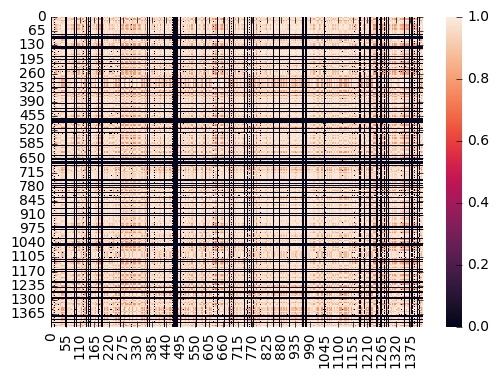

In [59]:
sns.heatmap(fin)
plt.show()

In [81]:
icecream.name.iloc[120]

'key food, all natural ice cream, vanilla bean'

In [82]:
icecream.ingredients.iloc[120]

'skim milk, cream, sugar, corn syrup, whey, contains 2% or less of vanilla extract, locust bean gum, guar gum, carrageenan, vanilla bean specs.'

In [83]:
fin[120]

array([0., 0., 0., ..., 0., 0., 0.])

In [84]:
nl[120]

['skim milk',
 'cream',
 'sugar',
 'corn syrup',
 'whey',
 'contains 2',
 'or less of vanilla extract',
 'locust bean gum',
 'guar gum',
 'carrageenan',
 'vanilla bean specs']

In [ ]:
icecream.ingredients.iloc[320]

In [77]:
print(fin[320].max(),fin[320].argmax())
icecream[['name','ingredients']].iloc[[320,67]]

,name,ingredients
16170,ice cream sandwiches,"ice cream portion: milkfat and nonfat milk, co..."
1687,"roundy's, ice cream sandwiches, vanilla","ice cream: milkfat and nonfat milk, sweet crea..."


In [78]:
icecream[['name','ingredients']].iloc[67]

name                     roundy's, ice cream sandwiches, vanilla
ingredients    ice cream: milkfat and nonfat milk, sweet crea...
Name: 1687, dtype: object

In [79]:
icecream[['name','ingredients']].iloc[320]

name                                        ice cream sandwiches
ingredients    ice cream portion: milkfat and nonfat milk, co...
Name: 16170, dtype: object

In [86]:
 z

TypeError: '[False False False ... False False False]' is an invalid key

In [102]:
icecream[icecream.name=="roundy's, ice cream sandwiches, vanilla"].iloc[0]

NDB_Number                                                             45012671
long_name                               ROUNDY'S, ICE CREAM SANDWICHES, VANILLA
data_source                                                                  LI
gtin_upc                                                            1.11506e+10
manufacturer                                                           ROUNDY'S
date_modified                                               2017-06-25 00:11:41
date_available                                              2017-06-25 00:11:41
ingredients_english           ICE CREAM: MILKFAT AND NONFAT MILK, SWEET CREA...
name                                    roundy's, ice cream sandwiches, vanilla
ingredients                   ice cream: milkfat and nonfat milk, sweet crea...
Unnamed: 0                                                                45927
satfat                                                                        5
satfat_uom                              

In [115]:
cols=pd.Series((icecream.manufacturer+': '+icecream.name))
df=pd.DataFrame(fin,columns=cols, index=cols)

In [116]:
df.head()

,"Oregon Ice Cream, LLC: julie's, organic ice cream, toasty almond coconut chip","Straus Family Creamery: straus family creamery, organic super premium ice cream, vanilla chocolate chip","Double Rainbow Gourmet Ice Creams, Inc.: double rainbow, ice cream, mint chocolate chip","Wells Enterprises, Inc.: ice cream bar","Weis Markets, Inc.: premium ice cream","All-American Bottling Corp.: ben & jerry's, chubby hubby, vanilla malt ice cream with fudge & peanut buttery swirls","Wells Enterprises, Inc.: blue bunny, premium ice cream, vanilla bean","Wells Enterprises, Inc.: blue bunny, premium ice cream, cookies & cream","Wells Enterprises, Inc.: blue bunny, premium ice cream, banana split","Wells Enterprises, Inc.: blue bunny, premium ice cream, coffee break",...,"SaltiSweet Ice Cream Factory LLC: salti sweet ice cream factory, organic ice cream, golden salted caramel",The Kroger Co.: white ice cream cone cake,MAGNOLIA: ice cream,MAMITA'S: coconut ice cream,"Giant Eagle, Inc.: creamery classics premium ice cream","Giant Eagle, Inc.: premium ice cream",Sunbeam-Oster Household Products: ice cream mix,ACME FRESH MARKET: ice cream,ACME FRESH MARKET: ice cream,ACME FRESH MARKET: ice cream
"Oregon Ice Cream, LLC: julie's, organic ice cream, toasty almond coconut chip",1.000000,0.999682,0.0,0.0,0.994329,0.0,0.0,0.969085,0.969085,0.826696,...,0.999682,0.996345,0.824978,0.0,0.977720,0.824978,0.992983,0.969085,0.824978,0.962849
"Straus Family Creamery: straus family creamery, organic super premium ice cream, vanilla chocolate chip",0.999682,1.000000,0.0,0.0,0.993623,0.0,0.0,0.968549,0.968549,0.825531,...,1.000000,0.996221,0.823843,0.0,0.977408,0.823843,0.992694,0.968549,0.823843,0.962319
"Double Rainbow Gourmet Ice Creams, Inc.: double rainbow, ice cream, mint chocolate chip",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Wells Enterprises, Inc.: ice cream bar",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"Weis Markets, Inc.: premium ice cream",0.994329,0.993623,0.0,0.0,1.000000,0.0,0.0,0.984096,0.984096,0.866527,...,0.993623,0.997100,0.865498,0.0,0.988602,0.865498,0.987913,0.984096,0.865498,0.979268


In [177]:
p='Straus Family Creamery: straus family creamery, organic super premium ice cream, vanilla chocolate chip'
df[df.index !=p][p].argmax()

'DOUBLE RAINBOW: organic ice cream'

In [182]:
def foodforme(product):
    p=product
     
    
    return df[df.index !=p][p].argmax()
    
    
    
    
    
    

In [184]:
foodforme('Double Rainbow Gourmet Ice Creams, Inc.: double rainbow, ice cream, mint chocolate chip')

"Oregon Ice Cream, LLC: julie's, organic ice cream, toasty almond coconut chip"

In [205]:
def foodforme(product):
    p=product
    if p in df.columns:
        answer=df[df.index !=p][p].argmax()
    else: 
        answer=print('foodforme has no good recommendation for "', p,'"')
    
    return answer
foodforme('trader joe')

foodforme has no good recommendation for " trader joe "


In [583]:
model.wv.most_similar(positive='strawberries'.split())

[('cherries', 0.9987879395484924),
 ('pectin', 0.998450756072998),
 ('ice cream', 0.9983875751495361),
 ('natural flavors', 0.998315691947937),
 ('buttermilk', 0.9982729554176331),
 ('strawberry puree', 0.9980952739715576),
 ('potassium sorbate', 0.9980021715164185),
 ('modified cornstarch', 0.9977269768714905),
 ('high fructose corn syrup', 0.9977269768714905),
 ('modified corn starch', 0.997607946395874)]

# for you to try 
#model.doesnt_match("vanilla cream  water sugar".split())
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
[('queen', 0.50882536)]
model.doesnt_match("breakfast cereal dinner lunch";.split())
'cereal'
model.similarity('woman', 'man')
0.73723527
from gensim.models import KeyedVectors
path = get_tmpfile("wordvectors.kv")
model.wv.save(path)
#wv = KeyedVectors.load("model.wv", mmap='r')
#vector = wv['orange']  # numpy vector of a word
model.wv.most_similar(positive='coconut cream water'.split())
words=list(model.wv.vocab)
words[:10]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(model[model.wv.vocab])
plt.scatter(result[:, 0], result[:, 1])
plt.show()
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [ ]:
def foodforme(product,concern):
    newdf=icecream[icecream['pcat']=='ice cream'][icecream['concern']=='lowfat']


    Run cosine similarity cosine_similarity(X[i].reshape(1,-1) , X[i+1].reshape(1,-1) )[0][0]    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [15]:
products.pcat2[:100]

0      True
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19     True
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27     True
28     True
29    False
      ...  
70    False
71    False
72    False
73     True
74    False
75    False
76    False
77    False
78    False
79    False
80    False
81    False
82    False
83    False
84    False
85    False
86    False
87    False
88    False
89     True
90     True
91     True
92    False
93    False
94    False
95    False
96    False
97    False
98    False
99    False
Name: pcat2, dtype: object

In [3]:
fullpro=products[products['ingredients_english'].notnull()].drop_duplicates(subset=['ingredients_english']) 
#.drop_duplicates(subset=['ingredients_english'],keep=last)
#x=fullpro[fullpro['ingredients_english']]
x=fullpro['ingredients_english']
x[:5]

with open('corpuslist.txt', 'w') as f:
    for item in corpus:
        f.write("%s\n" % item)

In [10]:
#x=products['ingredients_english'][products['ingredients_english'].notnull()]
#x[955:962]
#review=''
corpus = []
for i in x.index.tolist():
    review = x[i].split(':')
    #review=[x.replace(':',',') for x in review]

    review=[x.replace('*','') for x in review]
# problem might be with the :
    review=[x.replace('&','') for x in review]
    review=[x.replace('%','') for x in review]
    review=[x.replace('.','') for x in review]
    review=[x.replace('(','') for x in review]
    review=[x.replace(')','') for x in review]
    review=[x.replace(' ',' ') for x in review]
    review=[x.replace(',','') for x in review]
    #review=re.sub('[^a-zA-Z]', ' ', x[i])
    review =[x.lower() for x in review]
    review=[x.strip() for x in review]
    review=[x.replace(',','') for x in review]



    #review = [x.split(',') for x in review]
    #ps = PorterStemmer()
    #review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

len(corpus)

95357

In [11]:
al={} 
melcat=0

for j in corpus: 
    for ing in j.strip().split(','):
        for ind in ing.split():  
            if ind not in al: al[ind]=1
            if ind in al: al[ind]+=1   


In [180]:
listofTuples= sorted(al.items() , key=lambda x: x[1] )
listofTuples[15000:15050]

[('62', 9),
 ('protien', 9),
 ('tassos', 9),
 ('whole/nonfat', 9),
 ('grey', 9),
 ('hydrocholoride', 9),
 ('secret', 9),
 ('mineral]', 9),
 ('texture]', 9),
 ('agaricus', 9),
 ('<1', 9),
 ('vanillan', 9),
 ('acini', 9),
 ('cum', 9),
 ('pablano', 9),
 ('mono-diglyceride', 9),
 ('apo-carotenal]', 9),
 ('[mushrooms', 9),
 ('meal]', 9),
 ('artifcial', 9),
 ('flecks', 9),
 ('c;', 9),
 ('arginate', 9),
 ('nitrite;', 9),
 ('dulce', 10),
 ('dissolving', 10),
 ('b-1', 10),
 ('single', 10),
 ('+sugar', 10),
 ('shaped', 10),
 ('giant', 10),
 ('o', 10),
 ('molasses+', 10),
 ('crawfish', 10),
 ('acidnatural', 10),
 ('prime', 10),
 ('charbroiled', 10),
 ('preperation]', 10),
 ('broken', 10),
 ('madhava', 10),
 ('threadfin', 10),
 ('pulled', 10),
 ('k-1', 10),
 ('[fumaric', 10),
 ('tomatoe', 10),
 ('ghirardelli', 10),
 ('[peaches', 10),
 ('flagship', 10),
 ('deglet', 10),
 ('farmed', 10)]

In [13]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 100, min_df= 0.20)
X = cv.fit_transform(corpus).toarray()
#y = b['bistar'].values
X.shape
#cv = CountVectorizer(max_df =0.9,)

tri1 = cv.fit_transform(corpus).toarray()

print((X.mean(axis=1)==0).sum()*1)

print(X.shape)

3755
(95357, 25)


In [186]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer( min_df= 0.30)
X = cv.fit_transform(corpus).toarray()
#y = b['bistar'].values
X.shape
#cv = CountVectorizer(max_df =0.9,)

#tri1 = cv.fit_transform(corpus).toarray()

print((X.mean(axis=1)==0).sum()*1)

print(X.shape)

4642
(95357, 10)


In [213]:
corpus2=['hydrolyzed','propionate','cinnamon','parsley','locust','celery','sesame','pork','peanuts','peanut','polysorbate','cheddar','pectin','mustard','beans','roasted','pyrophosphate','almonds','flavoring','liquor','chili','grain','freshness','monocalcium','seed','apple','palmitate','beef','molasses','olive','leavening','alkali','tapioca','citrate','bleached','cottonseed','gluten','processed','turmeric','partially','chloride','cornstarch','fat','seeds','kernel','distilled','onions','green','malted','paste','honey','potato','carrageenan','annatto','emulsifier','tomatoes','cellulose','eggs','sauce','solids','puree','benzoate','skim','culture','thiamin','lactic','soda','sulfate','dioxide','bean','spice','bicarbonate','ascorbic','cultures','cultured','barley','egg','lemon','hydrogenated','coconut','food','peppers','chicken','brown','baking','white','sorbate','dehydrated','guar','high','paprika','disodium','fructose','caramel','diglycerides','preservative','nonfat','maltodextrin','thiamine','cane','vanilla','protein','tomato','sunflower','reduced','pasteurized','xanthan','enzymes','rice','dextrose','sea','canola','pepper','whole','enriched','potassium','concentrate','chocolate','whey','iron','vegetable','niacin','cream','yeast','mononitrate','phosphate','riboflavin','onion','spices','folic','butter','modified','yellow','flavors','extract','vinegar','cocoa','calcium','palm','juice','vitamin','soybean','lecithin','cheese','artificial','garlic','citric','starch','gum','soy','syrup','powder','wheat','sodium','organic','natural','milk','corn','water','flour','acid','oil','sugar']

In [216]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(corpus2).toarray()
#y = b['bistar'].values
X.shape
#cv = CountVectorizer(max_df =0.9,)

#tri1 = cv.fit_transform(corpus).toarray()

print((X.mean(axis=1)==0).sum()*1)

print(X.shape)

0
(163, 163)


In [16]:
%timeit
trial=[]
prodsims={}
for product in fullpro[:1].long_name:
    for i in range(len(X)-1):
            trial.append(cosine_similarity(X[i].reshape(1,-1) , X[i+1].reshape(1,-1) )[0][0] )
            prodsims[product]= trial
prodsims

{'MOCHI ICE CREAM BONBONS': [0.43519413988924466,
  0.84866842479150573,
  0.90748521297303031,
  0.90748521297303031,
  1.0000000000000002,
  0.85839507527895209,
  0.81110710565381261,
  0.64699663922063055,
  0.53916386601719202,
  0.81649658092772603,
  0.47140452079103179,
  0.57735026918962584,
  0.70710678118654746,
  0.5,
  0.70710678118654746,
  0.70710678118654746,
  0.47434164902525688,
  0.83666002653407556,
  0.12598815766974239,
  0.66666666666666663,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.93933643662772404,
  0.92354814518279893,
  0.7283570407292298,
  0.33968311024337877,
  0.81649658092772603,
  0.1889822365046136,
  0.3779644730092272,
  0.28867513459481292,
  0.57735026918962584,
  0.22360679774997896,
  0.78935221737632633,
  0.78935221737632633,
  0.89442719099991586,
  0.86602540378443882,
  0.48112522432468818,
  0.15075567228888181,
  0.043519413988924463,
  0.86602540378443882,
  0.66697296884991564,
  0.41367015199601531,
  0.73854894587599662,
  1.0000000000

In [18]:
sorted(prodsims['MOCHI ICE CREAM BONBONS'],reverse=True)[:100]

[1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000000002,
 1.0000000000

In [217]:
trial=[]
prodsims={}
prodsimsmax={}
prodsi={}


for product in fullpro[:1].long_name:
    for i in range(len(fullpro)-1):
        trial.append(cosine_similarity(X[i].reshape(1,-1) , X[i+1].reshape(1,-1) )[0][0] )
    prodsims[product]= trial
    prodsimsmax[product]=np.argsort(trial)[-10:]
    prodsi[product]=np.sort(trial[-10:])
fullpro['Matches']=fullpro['long_name'].map(prodsimsmax)
prodsimsmax

IndexError: index 163 is out of bounds for axis 0 with size 163

In [125]:
for i in [91600,  7907, 44758,  1390,  4944,  4943, 91597, 81483, 93536, 40263]:
    print(fullpro.iloc[i].ingredients_english, fullpro.iloc[i].long_name )

0.25819888974716115

In [208]:
fullpro['Matches'].head()
for i in fullpro.iloc[:1].Matches:
    print(fullpro.iloc[i].long_name )  

114614                               HOMEMADE PICANTE SALSA
8974                              SHOPRITE, SMALL RED BEANS
55659                                 Red Gold 14oz Ketchup
1442              THE GREAT ORGANIC UNCURED CHICKEN HOT DOG
5354      ROAD'S END ORGANICS, DAIRY FREE MAC & CHREESE,...
5353      ROAD'S END ORGANICS, DAIRY FREE PENNE & CHREES...
114611                                              BAR-B-Q
102034                      VIVA SKIM DELIGHT FAT FREE MILK
117132                                           SNACK CAKE
49718                                           SWISS ROLLS
Name: long_name, dtype: object


In [52]:
#j2 = sorted(i for i in j if i >= 5)
enlist=sorted(l for l in prodsims['MOCHI ICE CREAM BONBONS'] if l>1)
len(enlist)

671

In [53]:
np.argsort(enlist)[-5:]

array([230,   1, 669, 668, 670])

In [58]:
fullpro.iloc[[230,   1, 669, 668, 670]]

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english
244,45002057,100% ORGANIC EINKORN WHOLE WHEAT PASTA LINGUINE,LI,8.154210e+11,JOVIAL,2018-04-05 06:53:46,2018-04-05 06:53:46,"ORGANIC WHOLE GRAIN EINKORN, WATER."
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5.051379e+12,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE..."
691,45003024,CAKE CUPS,LI,2.114024e+10,"Winn-Dixie Stores, Inc.",2018-05-12 05:13:59,2018-05-12 05:13:59,"ENRICHED WHEAT FLOUR (CONTAINS NIACIN, REDUCED..."
690,45003016,"RISING MOON ORGANICS, BUTTERNUT SQUASH RAVIOLI",LI,7.850306e+11,"United Natural Foods, Inc.",2018-05-12 01:56:08,2018-05-12 01:56:08,"PASTA INGREDIENTS: ORGANIC UNBLEACHED FLOUR, W..."
692,45003025,"REGGIE'S, SUNFLOWER SEEDS",LI,7.172570e+10,American Importing Co. Inc.,2018-05-12 05:12:30,2018-05-12 05:12:30,"ROASTED SUNFLOWER SEEDS, SALT."


In [59]:
(enlist)[-5:]

[1.0000000000000002,
 1.0000000000000002,
 1.0000000000000004,
 1.0000000000000004,
 1.0000000000000004]

In [475]:
plt.hist(prodsims['MOCHI ICE CREAM BONBONS'] )
plt.show()

KeyError: 'MOCHI ICE CREAM BONBONS'

In [478]:
pd.DataFrame(prodsims).to_csv('fullpro.csv')

In [476]:
fullpro.head()

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,Matches
0,45001524,MOCHI ICE CREAM BONBONS,LI,1.902213e+10,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...","[91600, 7907, 44758, 1390, 4944, 4943, 91597, ..."
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5.051379e+12,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",NaN
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5.051379e+12,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",NaN
3,45001530,BARBECUE SAUCE,LI,5.051379e+12,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",NaN
4,45001531,BARBECUE SAUCE,LI,5.051379e+12,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",NaN


In [481]:
fullpro.Matches[0]

array([91600,  7907, 44758,  1390,  4944,  4943, 91597, 81483, 93536, 40263])